# Approach 1:

This approach is mainly based on multiclass classification of wheter this is a normal traffic or one of the eight attack exist.
In this notebook there are two experiments: first one is running our stacking model which is a combination between Logistic Regreesion and Decision Tree, on the whole features without any feature selection.

Second one is based on using XGboost as a feature selection and then run the stacking model once again.

# **Required Library**

In [1]:
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import random 
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix,classification_report,confusion_matrix,accuracy_score
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler
from sklearn.metrics import f1_score
import time
import json

from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting


import matplotlib.pyplot as plt
import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import random 

from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix,classification_report,confusion_matrix,accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix,classification_report,accuracy_score

# **Load Data**

In [2]:
df_TR = pd.read_csv(r"UNSW_NB15_testing-set.csv")
df_TS = pd.read_csv(r"UNSW_NB15_training-set.csv")
df_TR

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,13,24,0,0,0,24,24,0,Generic,1
175337,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,...,1,2,0,0,0,1,1,0,Shellcode,1
175338,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,3,13,0,0,0,3,12,0,Generic,1
175339,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,14,30,0,0,0,30,30,0,Generic,1


In [3]:
df_TR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

# Data Preprocessing

**Drop Id and label Coulmns**

In [4]:
to_drop=['id','label']
df_TR.drop(to_drop, inplace=True, axis=1)
df_TS.drop(to_drop, inplace=True, axis=1)

**Checking for Nan and Null in training data**

In [5]:
pd.set_option('display.max_columns', None)

isna = pd.DataFrame(df_TR.isna().sum().values.reshape(1, 43), columns=df_TR.columns, index=['NA'])
isnull = pd.DataFrame(df_TR.isnull().sum().values.reshape(1, 43), columns=df_TR.columns, index=['Null'])

print(pd.concat([isna, isnull]).sum().sum())
pd.concat([isna, isnull])

0


,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
NA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Checking for Nan and Null in testing data**

In [6]:
# Check for NAN and NULL in testing data
pd.set_option('display.max_columns', None)

isna = pd.DataFrame(df_TS.isna().sum().values.reshape(1, 43), columns=df_TS.columns, index=['NA'])
isnull = pd.DataFrame(df_TS.isnull().sum().values.reshape(1, 43), columns=df_TS.columns, index=['Null'])

print(pd.concat([isna, isnull]).sum().sum())
pd.concat([isna, isnull])

0


,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
NA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Checking for any garbage in data**

In [7]:
df_TR=df_TR.iloc[df_TR['service'].replace(['-'], np.nan).dropna().index.to_numpy(), :].reset_index(drop = True)
df_TS=df_TS.iloc[df_TS['service'].replace(['-'], np.nan).dropna().index.to_numpy(), :].reset_index(drop = True)

**Check for duplication**

In [8]:
duplication = df_TR[df_TR.duplicated()]

In [9]:
df_TR.describe()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
count,81173.000000,81173.000000,81173.000000,8.117300e+04,8.117300e+04,8.117300e+04,81173.000000,81173.000000,8.117300e+04,8.117300e+04,81173.000000,81173.000000,81173.000000,81173.000000,81173.000000,81173.000000,81173.000000,8.117300e+04,8.117300e+04,81173.000000,81173.000000,81173.000000,81173.000000,81173.000000,81173.000000,81173.000000,8.117300e+04,81173.000000,81173.000000,81173.000000,81173.000000,81173.000000,81173.000000,81173.000000,81173.000000,81173.000000,81173.000000,81173.000000,81173.0
mean,0.895342,21.069247,17.882178,1.443658e+04,1.430574e+04,1.072052e+05,169.317211,79.585071,4.944171e+07,2.244341e+05,6.721213,6.568810,43.035210,41.121439,2917.998097,814.391169,105.985857,8.950272e+08,8.932812e+08,105.985857,0.037181,0.018160,0.019020,128.117687,121.890826,0.222549,4.574160e+03,13.525236,1.285637,10.106563,9.336023,7.315659,13.635100,0.032289,0.032289,0.278960,10.538898,13.484779,0.0
std,4.501456,188.825991,131.947926,2.468835e+05,1.740212e+05,1.717474e+05,102.939504,110.907217,8.103404e+07,1.020976e+06,92.927155,63.907123,236.042050,258.349633,21217.422316,4532.932092,125.672536,1.331173e+09,1.325500e+09,125.672536,0.067737,0.035531,0.035090,212.058072,250.771747,1.127905,7.916562e+04,13.442824,0.838901,9.993031,10.195119,7.093979,13.447029,0.183739,0.183739,1.002468,9.979971,13.463620,0.0
min,0.000001,1.000000,0.000000,1.000000e+02,0.000000e+00,0.000000e+00,31.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,43.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0
25%,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,4.643371e+01,62.000000,0.000000,1.883047e+04,0.000000e+00,0.000000,0.000000,0.007000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000e+00,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.0
50%,0.000995,2.000000,2.000000,1.300000e+02,1.620000e+02,4.366812e+03,254.000000,29.000000,4.456508e+06,1.584034e+03,0.000000,0.000000,0.009000,0.002000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.000000,44.000000,0.000000,0.000000e+00,5.000000,1.000000,6.000000,2.000000,2.000000,6.000000,0.000000,0.000000,0.000000,7.000000,5.000000,0.0
75%,0.647170,10.000000,10.000000,9.640000e+02,1.538000e+03,1.250000e+05,254.000000,252.000000,5.700000e+07,4.626889e+04,2.000000,2.000000,43.066462,47.889897,2436.159270,115.743836,255.000000,1.721137e+09,1.716718e+09,255.000000,0.057231,0.014610,0.037686,83.000000,89.000000,0.000000,0.000000e+00,26.000000,2.000000,17.000000,16.000000,16.000000,26.000000,0.000000,0.000000,0.000000,17.000000,26.000000,0.0
max,59.999046,9616.000000,10974.000000,1.296523e+07,1.465555e+07,1.000000e+06,255.000000,254.000000,2.304000e+09,2.242273e+07,4803.000000,5484.000000,13992.212000,13992.285000,941255.392100,289388.269700,255.000000,4.294959e+09,4.294776e+09,255.000000,1.490702,0.513125,1.424061,1371.000000,1458.000000,172.000000,6.558056e+06,52.000000,6.000000,51.000000,51.000000,31.000000,52.000000,4.000000,4.000000,30.000000,60.000000,52.000000,0.0


In [10]:
df_TS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35179 entries, 0 to 35178
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dur                35179 non-null  float64
 1   proto              35179 non-null  object 
 2   service            35179 non-null  object 
 3   state              35179 non-null  object 
 4   spkts              35179 non-null  int64  
 5   dpkts              35179 non-null  int64  
 6   sbytes             35179 non-null  int64  
 7   dbytes             35179 non-null  int64  
 8   rate               35179 non-null  float64
 9   sttl               35179 non-null  int64  
 10  dttl               35179 non-null  int64  
 11  sload              35179 non-null  float64
 12  dload              35179 non-null  float64
 13  sloss              35179 non-null  int64  
 14  dloss              35179 non-null  int64  
 15  sinpkt             35179 non-null  float64
 16  dinpkt             351

In [11]:
df_TS.describe()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
count,35179.000000,35179.000000,35179.000000,3.517900e+04,3.517900e+04,3.517900e+04,35179.000000,35179.000000,3.517900e+04,3.517900e+04,35179.000000,35179.000000,35179.000000,35179.000000,3.517900e+04,35179.000000,35179.000000,3.517900e+04,3.517900e+04,35179.000000,35179.000000,35179.000000,35179.000000,35179.000000,35179.000000,35179.000000,3.517900e+04,35179.000000,35179.000000,35179.000000,35179.000000,35179.000000,35179.000000,35179.000000,35179.000000,35179.000000,35179.000000,35179.000000,35179.0
mean,0.578372,17.244180,15.784985,1.091370e+04,1.284170e+04,1.050469e+05,173.733534,77.569686,4.835463e+07,1.725737e+05,5.237159,5.880298,36.811084,40.287222,2.886289e+03,625.791216,99.763069,8.437637e+08,8.339823e+08,99.755820,0.035576,0.017533,0.018043,120.025185,109.913386,0.216436,3.718170e+03,13.383183,1.330055,9.461355,8.804855,6.622076,12.028142,0.019387,0.019614,0.299156,9.776458,13.325080,0.0
std,2.679221,164.539755,138.422247,2.146349e+05,1.836704e+05,1.603883e+05,101.518730,110.793561,7.596765e+07,8.284099e+05,80.556308,67.643599,261.407149,320.343167,2.754703e+04,4165.115576,124.448194,1.306200e+09,1.295922e+09,124.446578,0.065367,0.034941,0.033046,200.446085,237.306147,0.812169,5.813653e+04,14.564981,0.786215,11.302811,11.521412,8.026752,15.052774,0.138704,0.140707,0.948256,11.275218,14.585591,0.0
min,0.000000,1.000000,0.000000,6.500000e+01,0.000000e+00,0.000000e+00,31.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,43.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0
25%,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,5.367212e+01,62.000000,0.000000,2.185568e+04,0.000000e+00,0.000000,0.000000,0.007000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000e+00,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.0
50%,0.000011,2.000000,0.000000,1.140000e+02,0.000000e+00,9.090909e+04,254.000000,0.000000,4.145454e+07,0.000000e+00,0.000000,0.000000,0.010000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000e+00,6.000000,2.000000,4.000000,3.000000,2.000000,3.000000,0.000000,0.000000,0.000000,4.000000,6.000000,0.0
75%,0.575348,10.000000,8.000000,8.440000e+02,1.168000e+03,1.250000e+05,254.000000,252.000000,5.700000e+07,2.225624e+04,2.000000,2.000000,37.114605,44.025250,2.167454e+03,101.292871,255.000000,1.562271e+09,1.516507e+09,255.000000,0.053360,0.009726,0.034040,81.000000,89.000000,0.000000,0.000000e+00,25.000000,2.000000,16.000000,15.000000,12.000000,25.000000,0.000000,0.000000,0.000000,16.000000,25.000000,0.0
max,59.999527,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,253.000000,2.304000e+09,2.082111e+07,5319.000000,5507.000000,11141.673300,13927.095000,1.107490e+06,463199.240100,255.000000,4.294718e+09,4.294325e+09,255.000000,0.606397,0.352932,0.424028,1369.000000,1500.000000,131.000000,5.242880e+06,59.000000,6.000000,59.000000,59.000000,38.000000,59.000000,2.000000,2.000000,16.000000,60.000000,59.000000,0.0


# **visualize data**

Text(0.5, 1.0, 'Number of attacks per Attack caterogy')

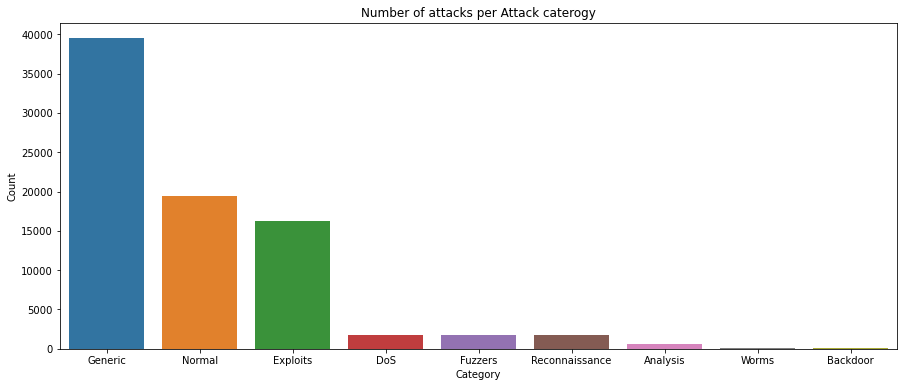

In [12]:
plt.figure(figsize=(15,6))
sns.barplot(x=df_TR['attack_cat'].value_counts().index,y=df_TR['attack_cat'].value_counts())
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Number of attacks per Attack caterogy')

# **Label Encoding**

In [13]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# label Encoding for Training data
le.fit(df_TR['proto'])
df_TR['proto']=le.transform(df_TR['proto'])
df_TS['proto']=le.transform(df_TS['proto'])

le.fit(df_TR['service'])
df_TR['service']=le.transform(df_TR['service'])
df_TS['service']=le.transform(df_TS['service'])

df_TR['state'] =df_TR['state'].replace( ['INT', 'FIN', 'CON', 'REQ', 'RST', 'ECO','no', 'URN', 'PAR', 'ACC', 'CLO'],[ 0 , 1, 2, 3, 4, 5, 6, 7, 8 ,9 ,10 ])
df_TS['state'] =df_TS['state'].replace( ['INT', 'FIN', 'CON', 'REQ', 'RST', 'ECO','no', 'URN', 'PAR', 'ACC', 'CLO'],[ 0 , 1, 2, 3, 4, 5, 6, 7, 8 ,9 ,10 ])

le.fit(df_TR['attack_cat'])
df_TR['attack_cat']=le.transform(df_TR['attack_cat'])
df_TS['attack_cat']=le.transform(df_TS['attack_cat'])

# **Divide data into Features and Labels**

In [14]:
X_TR =df_TR.drop('attack_cat',axis=1) 
Y_TR =df_TR['attack_cat']

X_TS =df_TS.drop('attack_cat',axis=1) 
Y_TS =df_TS['attack_cat']

# **Data Normalization**

In [15]:
import pandas as pd
from sklearn import preprocessing
# data normalization for training data 
X = X_TR.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X)
X_TR = pd.DataFrame(x_scaled,columns=X_TR.columns)

# data normalization for Test data 
X = X_TS.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X)
X_TS = pd.DataFrame(x_scaled,columns=X_TS.columns)


#  **Stacking Model without Feature Selection**

>lr 0.916 (0.002)
>cart 0.930 (0.002)
>stacking 0.929 (0.002)


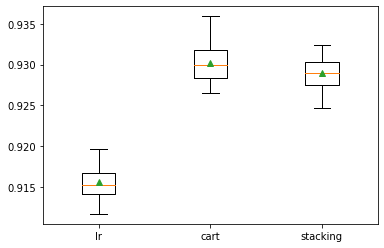

In [16]:
# compare ensemble to each baseline classifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot

# get a stacking ensemble of models
def Stacking():
# define the base models
  Models_list = list()
  Models_list.append(('cart', DecisionTreeClassifier()))
  Models_list.append(('lr', LogisticRegression()))
# define meta learner model
  final_est = LogisticRegression()
# define the stacking ensemble
  model = StackingClassifier(estimators=Models_list, final_estimator=final_est, cv=5)
  return model

# get a list of models to evaluate
def Models():
	models = dict()
	models['lr'] = LogisticRegression()
	models['cart'] = DecisionTreeClassifier()
	models['stacking'] =Stacking()
	return models

# evaluate a give model using cross-validation
def evaluate(model, X_TR, Y_TR):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	Scores = cross_val_score(model,X_TR, Y_TR, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return Scores

# get the models to evaluate
models = Models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate(model, X_TR, Y_TR)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [17]:
model.fit(X_TR, Y_TR)

C:\Users\ayamo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ayamo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

StackingClassifier(cv=5,
                   estimators=[('cart', DecisionTreeClassifier()),
                               ('lr', LogisticRegression())],
                   final_estimator=LogisticRegression())

In [18]:
y_pred1=model.predict(X_TS)

from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score( Y_TS, y_pred1))

Accuracy: 0.9007362346854657


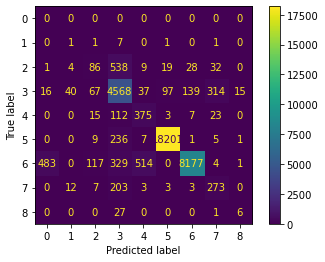

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.02      0.09      0.03        11
           2       0.28      0.12      0.17       717
           3       0.76      0.86      0.81      5293
           4       0.40      0.70      0.51       535
           5       0.99      0.99      0.99     18460
           6       0.98      0.85      0.91      9625
           7       0.42      0.54      0.47       504
           8       0.26      0.18      0.21        34

    accuracy                           0.90     35179
   macro avg       0.46      0.48      0.45     35179
weighted avg       0.92      0.90      0.91     35179



C:\Users\ayamo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

plot_confusion_matrix(model, X_TS, Y_TS,values_format= "d")  
plt.show()
print(classification_report( Y_TS, y_pred1))

# Using XGBOOSt for feature selection

In [ ]:
#pip install xgboost

C:\Users\ayamo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:33:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Feature: 0, Score: 0.00081
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00195
Feature: 3, Score: 0.00287
Feature: 4, Score: 0.00125
Feature: 5, Score: 0.00234
Feature: 6, Score: 0.01770
Feature: 7, Score: 0.00479
Feature: 8, Score: 0.00078
Feature: 9, Score: 0.05082
Feature: 10, Score: 0.52128
Feature: 11, Score: 0.00043
Feature: 12, Score: 0.00040
Feature: 13, Score: 0.00110
Feature: 14, Score: 0.00153
Feature: 15, Score: 0.00036
Feature: 16, Score: 0.00080
Feature: 17, Score: 0.00035
Feature: 18, Score: 0.00039
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00026
Feature: 21, Score: 0.00028
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00065
Feature: 24, Score: 0.00059

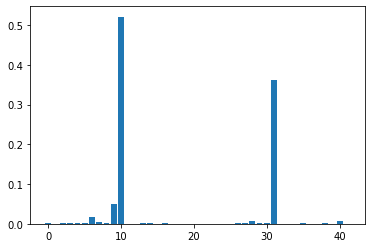

[04:34:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Index(['sttl', 'dttl', 'ct_state_ttl'], dtype='object')


In [21]:
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

model = XGBClassifier()
model.fit(X_TR, Y_TR)
# get importance
importance = model.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

from sklearn.feature_selection import SelectFromModel
model1=SelectFromModel(XGBClassifier(n_estimators = 100))
model1.fit(X_TR, Y_TR) 

model1.get_support()

selected_feat= X_TR.columns[(model1.get_support())]
len(selected_feat)
print(selected_feat)

**Update the training columns based on the highest 5 scores**

In [22]:
X1_TR=X_TR[['sttl', 'dttl', 'ct_state_ttl','sbytes','trans_depth']]
X1_TS=X_TS[['sttl', 'dttl', 'ct_state_ttl','sbytes','trans_depth']]

# **Stacking Model after feature selection**

>lr 0.901 (0.002)
>cart 0.923 (0.002)
>stacking 0.920 (0.002)


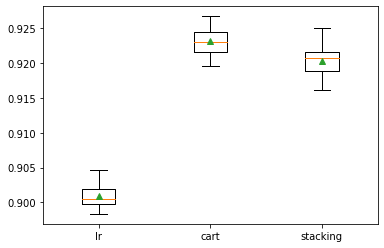

In [23]:
# compare ensemble to each baseline classifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot

# get a stacking ensemble of models
def Stacking():
# define the base models
  Models_list = list()
  Models_list.append(('cart', DecisionTreeClassifier()))
  Models_list.append(('lr', LogisticRegression()))

  final_est = LogisticRegression()

# define the stacking ensemble
  model = StackingClassifier(estimators=Models_list, final_estimator=final_est, cv=5)
  return model

# get a list of models to evaluate
def Models():
	models = dict()
	models['lr'] = LogisticRegression()
	models['cart'] = DecisionTreeClassifier()
	models['stacking'] =Stacking()
	return models

# evaluate the model using cross validation
def evaluate(model, X1_TR, Y_TR):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	Scores = cross_val_score(model,X1_TR, Y_TR, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return Scores

# get the models to evaluate
models = Models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate(model, X1_TR, Y_TR)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [27]:
model.fit(X1_TR, Y_TR)

C:\Users\ayamo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ayamo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

StackingClassifier(cv=5,
                   estimators=[('cart', DecisionTreeClassifier()),
                               ('lr', LogisticRegression())],
                   final_estimator=LogisticRegression())

In [28]:
y_pred=model.predict(X1_TS)


#Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

# Model Accuracy, how often is the classifier correct
print("Accuracy:",metrics.accuracy_score( Y_TS, y_pred))


Accuracy: 0.8601154097615055


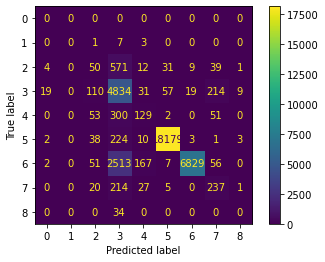

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00        11
           2       0.15      0.07      0.10       717
           3       0.56      0.91      0.69      5293
           4       0.34      0.24      0.28       535
           5       0.99      0.98      0.99     18460
           6       1.00      0.71      0.83      9625
           7       0.40      0.47      0.43       504
           8       0.00      0.00      0.00        34

    accuracy                           0.86     35179
   macro avg       0.38      0.38      0.37     35179
weighted avg       0.89      0.86      0.86     35179



C:\Users\ayamo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ayamo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
plot_confusion_matrix(model, X1_TS, Y_TS,values_format= "d")  
plt.show()

print(classification_report( Y_TS, y_pred))